<h1>Install and import Library<h1>

In [2]:
%pip install matplotlib
%pip install pandas openpyxl
%pip install seaborn
%pip install shapely
%pip install geodatasets
%pip install geopy
%pip install folium
%pip install ipywidgets
%pip install IPython
%pip install flask

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Dependencies
import pandas as pd
import geopandas as gpd
from pathlib import Path
import numpy as np
import os
import openpyxl
import zipfile
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import geodatasets
from geopy.geocoders import Nominatim
import folium
from folium import plugins
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
import ipywidgets as widgets
from IPython.display import display
from flask import Flask, render_template_string
import numpy as np
from scipy import stats


<h1> ETL - Load, transform and save data to SQL database <h1>

In [58]:
# Upzip geojson file 
zip_file_path = 'Resources/California_Fire_Perimeters.geojson.zip'

# Open the zip file in read mode
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the zip file
    zip_ref.extractall('Resources')

In [5]:
# Wildfire Data
# Name of the geojson file
file_js = Path('Resources/California_Fire_Perimeters.geojson')

In [6]:
# Step 1: Load Wildfire GeoJSON Data
wildfire_gdf = gpd.read_file(file_js)

In [7]:
if os.path.exists(file_js):
    # Delete the file
    os.remove(file_js)
    print(f"File '{file_js}' has been deleted.")
else:
    print(f"File '{file_js}' does not exist.")

File 'Resources/California_Fire_Perimeters.geojson' has been deleted.


In [8]:
# Display the first few rows to understand the structure
print(wildfire_gdf.head())

   OBJECTID   YEAR_ STATE AGENCY UNIT_ID  FIRE_NAME   INC_NUM  \
0         1  2023.0    CA    CDF     SKU  WHITWORTH  00004808   
1         2  2023.0    CA    LRA     BTU     KAISER  00010225   
2         3  2023.0    CA    CDF     AEU    JACKSON  00017640   
3         4  2023.0    CA    CDF     AEU     CARBON  00018821   
4         5  2023.0    CA    CDF     AEU    LIBERTY  00018876   

                      ALARM_DATE                      CONT_DATE  CAUSE  \
0  Sat, 17 Jun 2023 00:00:00 GMT  Sat, 17 Jun 2023 00:00:00 GMT    5.0   
1  Fri, 02 Jun 2023 00:00:00 GMT  Fri, 02 Jun 2023 00:00:00 GMT    5.0   
2  Sat, 01 Jul 2023 00:00:00 GMT  Sun, 02 Jul 2023 00:00:00 GMT    2.0   
3  Tue, 11 Jul 2023 00:00:00 GMT  Tue, 11 Jul 2023 00:00:00 GMT    9.0   
4  Tue, 11 Jul 2023 00:00:00 GMT  Wed, 12 Jul 2023 00:00:00 GMT   14.0   

   C_METHOD  OBJECTIVE  GIS_ACRES COMMENTS COMPLEX_NAME  \
0       1.0        1.0   5.729125     None         None   
1       1.0        1.0  13.602380     None    

In [9]:
# Extract column names
column_names = wildfire_gdf.columns
print("Column Names:", column_names)

Column Names: Index(['OBJECTID', 'YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME',
       'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'C_METHOD', 'OBJECTIVE',
       'GIS_ACRES', 'COMMENTS', 'COMPLEX_NAME', 'IRWINID', 'FIRE_NUM',
       'COMPLEX_ID', 'DECADES', 'geometry'],
      dtype='object')


In [10]:
# Check the minimum and maximum year in the dataset
min_year = wildfire_gdf['YEAR_'].min()
max_year = wildfire_gdf['YEAR_'].max()

print(f"Year Range: {min_year} to {max_year}")

Year Range: 1878.0 to 2023.0


In [11]:
# Step 2: Process Wildfire Data - Change column names
# Rename specific columns
wildfire_gdf = wildfire_gdf.rename(columns={
    'OBJECTID': 'ID',
    'YEAR_': 'Year',
    'STATE': 'State',
    'AGENCY': 'Agency',
    'UNIT_ID': 'Unit ID',
    'FIRE_NAME': 'Fire Name',
    'INC_NUM': 'Incident Number',
    'ALARM_DATE': 'Alarm Date',
    'CONT_DATE': 'Containment Date',
    'CAUSE': 'Cause',
    'C_METHOD': 'Collection Method',
    'OBJECTIVE': 'Management Objective',
    'GIS_ACRES': 'GIS Acres',
    'COMMENTS': 'Comments', 
    'COMPLEX_NAME': 'Complex Name',
    'IRWINID': 'IRWIN ID',
    'FIRE_NUM': 'Fire Number',
    'COMPLEX_ID': 'Complex ID',
    'DECADES':'Decades', 
    'geometry': 'Geometry'
})

In [12]:
#Confirm column name changes
column_names = wildfire_gdf.columns
print("Column Names:", column_names)

Column Names: Index(['ID', 'Year', 'State', 'Agency', 'Unit ID', 'Fire Name',
       'Incident Number', 'Alarm Date', 'Containment Date', 'Cause',
       'Collection Method', 'Management Objective', 'GIS Acres', 'Comments',
       'Complex Name', 'IRWIN ID', 'Fire Number', 'Complex ID', 'Decades',
       'Geometry'],
      dtype='object')


In [13]:
#Keep only a subset of columns for analysis
wildfire_gdf = wildfire_gdf[['ID', 'Year', 'State', 'Agency', 'Unit ID', 'Fire Name',
    'Incident Number', 'Alarm Date', 'Containment Date', 'Cause', 'GIS Acres', 
    'Comments','Complex Name', 'Fire Number', 'Decades','Geometry']]

In [14]:
# Calculate the centroid of each geometry (for polygons)
wildfire_gdf['Centroid'] = wildfire_gdf['Geometry'].centroid

# Extract latitude and longitude from the centroid
wildfire_gdf['Latitude'] = wildfire_gdf['Centroid'].y
wildfire_gdf['Longitude'] = wildfire_gdf['Centroid'].x

# Convert the geometry column to WKT (Well-Known Text)
wildfire_gdf['Geometry'] = wildfire_gdf['Geometry'].apply(lambda x: x.wkt)

/var/folders/zq/hzzbbfwd5zn47ndkhw43kdf80000gn/T/ipykernel_89079/1657914680.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  wildfire_gdf['Centroid'] = wildfire_gdf['Geometry'].centroid


In [15]:
#check transformed data
print(wildfire_gdf)

          ID    Year State Agency Unit ID  Fire Name Incident Number  \
0          1  2023.0    CA    CDF     SKU  WHITWORTH        00004808   
1          2  2023.0    CA    LRA     BTU     KAISER        00010225   
2          3  2023.0    CA    CDF     AEU    JACKSON        00017640   
3          4  2023.0    CA    CDF     AEU     CARBON        00018821   
4          5  2023.0    CA    CDF     AEU    LIBERTY        00018876   
...      ...     ...   ...    ...     ...        ...             ...   
22256  22257     NaN    CA    CCO     MRN     UKNOWN            None   
22257  22258     NaN    CA    CCO     MRN     UKNOWN            None   
22258  22259     NaN    CA    CCO     MRN     UKNOWN            None   
22259  22260     NaN    CA    CCO     MRN     UKNOWN            None   
22260  22261     NaN    CA    CCO     MRN     UKNOWN            None   

                          Alarm Date               Containment Date  Cause  \
0      Sat, 17 Jun 2023 00:00:00 GMT  Sat, 17 Jun 2023 00

In [16]:
#Check all columns
column_names = wildfire_gdf.columns
print("Column Names:", column_names)

Column Names: Index(['ID', 'Year', 'State', 'Agency', 'Unit ID', 'Fire Name',
       'Incident Number', 'Alarm Date', 'Containment Date', 'Cause',
       'GIS Acres', 'Comments', 'Complex Name', 'Fire Number', 'Decades',
       'Geometry', 'Centroid', 'Latitude', 'Longitude'],
      dtype='object')


In [17]:
#check the sample size
num_records = len(wildfire_gdf)
print(f"Number of records: {num_records}")

Number of records: 22261


In [18]:
#check fire data type
print(wildfire_gdf.dtypes)

ID                     int32
Year                 float64
State                 object
Agency                object
Unit ID               object
Fire Name             object
Incident Number       object
Alarm Date            object
Containment Date      object
Cause                float64
GIS Acres            float64
Comments              object
Complex Name          object
Fire Number           object
Decades              float64
Geometry              object
Centroid            geometry
Latitude             float64
Longitude            float64
dtype: object


In [19]:
#Transform Date columns to datetime
wildfire_gdf['Alarm Date'] = pd.to_datetime(wildfire_gdf['Alarm Date'], errors='coerce' )
wildfire_gdf['Containment Date'] = pd.to_datetime(wildfire_gdf['Containment Date'], errors='coerce' )

In [20]:
#check how many dates are not valid
invalid_dates = wildfire_gdf[wildfire_gdf['Alarm Date'].isna()]
print(invalid_dates)

          ID    Year State Agency Unit ID     Fire Name Incident Number  \
1561    1562  2019.0    CA    CDF     FKU          YORK        00005720   
1655    1656  2019.0    CA    USF     TNF        BORDER        00030785   
1659    1660  2019.0    CA    USF     INF         KELTY        00001465   
1661    1662  2019.0    CA    USF     HTF      TAMARACK        00030272   
1662    1663  2019.0    CA    CCO     ORC  BLUE DIAMOND        19059616   
...      ...     ...   ...    ...     ...           ...             ...   
22256  22257     NaN    CA    CCO     MRN        UKNOWN            None   
22257  22258     NaN    CA    CCO     MRN        UKNOWN            None   
22258  22259     NaN    CA    CCO     MRN        UKNOWN            None   
22259  22260     NaN    CA    CCO     MRN        UKNOWN            None   
22260  22261     NaN    CA    CCO     MRN        UKNOWN            None   

      Alarm Date Containment Date  Cause    GIS Acres  \
1561         NaT              NaT   14.0  

In [21]:
#Extract Year Month info from Alarm Date
wildfire_gdf['Date'] = wildfire_gdf['Alarm Date'].dt.to_period('M').dt.to_timestamp()

In [22]:
#check fire date column
print(wildfire_gdf['Date'])

0       2023-06-01
1       2023-06-01
2       2023-07-01
3       2023-07-01
4       2023-07-01
           ...    
22256          NaT
22257          NaT
22258          NaT
22259          NaT
22260          NaT
Name: Date, Length: 22261, dtype: datetime64[ns]


In [23]:
#Keep only a subset of columns for analysis - remove geometry and centroid data which SQL can't take
wildfire_gdf = wildfire_gdf[['ID', 'Year', 'State', 'Agency', 'Unit ID', 'Fire Name',
    'Incident Number', 'Alarm Date', 'Containment Date', 'Cause', 'Date',
    'GIS Acres', 'Comments', 'Complex Name', 'Fire Number', 'Decades',
    'Latitude', 'Longitude']]

In [24]:
#Connect to a SQL database
conn = sqlite3.connect('ca_wildfires.db')
c = conn.cursor()

In [25]:
# Write the GeoDataFrame to the SQLite database
# The table name will be 'wildfires' in this example
wildfire_gdf.to_sql('wildfires', conn, if_exists='replace', index=False)

22261

In [26]:
# Commit the transaction and close the connection
conn.commit()
conn.close()

print("GeoJSON data with latitude and longitude loaded successfully into the SQLite database.")

GeoJSON data with latitude and longitude loaded successfully into the SQLite database.


In [27]:
# Reconnect to the SQLite database
conn = sqlite3.connect('ca_wildfires.db')
c = conn.cursor()

# Example query: Get the first 5 records
c.execute('SELECT * FROM wildfires LIMIT 5')
rows = c.fetchall()

# Print the results
for row in rows:
    print(row)

# Close the connection
conn.close()

(1, 2023.0, 'CA', 'CDF', 'SKU', 'WHITWORTH', '00004808', '2023-06-17 00:00:00', '2023-06-17 00:00:00', 5.0, '2023-06-01 00:00:00', 5.729125, None, None, None, 2020.0, 41.53217495113126, -122.9121004744166)
(2, 2023.0, 'CA', 'LRA', 'BTU', 'KAISER', '00010225', '2023-06-02 00:00:00', '2023-06-02 00:00:00', 5.0, '2023-06-01 00:00:00', 13.60238, None, None, None, 2020.0, 39.83074335158788, -121.96285323349797)
(3, 2023.0, 'CA', 'CDF', 'AEU', 'JACKSON', '00017640', '2023-07-01 00:00:00', '2023-07-02 00:00:00', 2.0, '2023-07-01 00:00:00', 27.81446, None, None, None, 2020.0, 38.29510235241785, -120.90470630682653)
(4, 2023.0, 'CA', 'CDF', 'AEU', 'CARBON', '00018821', '2023-07-11 00:00:00', '2023-07-11 00:00:00', 9.0, '2023-07-01 00:00:00', 58.76023, None, None, None, 2020.0, 38.441969463285346, -120.98418641873987)
(5, 2023.0, 'CA', 'CDF', 'AEU', 'LIBERTY', '00018876', '2023-07-11 00:00:00', '2023-07-12 00:00:00', 14.0, '2023-07-01 00:00:00', 70.979, None, None, None, 2020.0, 38.2472269689214

In [28]:
# SQLite wildfire format 
#  TABLE "wildfires" CREATE TABLE "wildfires" (
# "ID" INTEGER,
#   "Year" REAL,
#   "State" TEXT,
#   "Agency" TEXT,
#   "Unit ID" TEXT,
#   "Fire Name" TEXT,
#   "Incident Number" TEXT,
#   "Alarm Date" TIMESTAMP,
#   "Containment Date" TIMESTAMP,
#   "Cause" REAL,
#   "GIS Acres" REAL,
#   "Comments" TEXT,
#   "Complex Name" TEXT,
#   "Fire Number" TEXT,
#   "Decades" REAL,
#   "Latitude" REAL,
#   "Longitude" REAL
# )

In [29]:
#List the top 10 fires by GIS Acres burned
# Connect to the SQLite database
conn = sqlite3.connect('ca_wildfires.db')

# Query to find the fire names associated with the top 10 largest GIS Acres
query = """
    SELECT "Fire Name", "GIS Acres", "Date"
    FROM wildfires
    ORDER BY "GIS Acres" DESC
    LIMIT 10;
"""

# Execute the query and load the results into a pandas DataFrame
top_fires = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Display the results
print(top_fires)

        Fire Name  GIS Acres                 Date
0  AUGUST COMPLEX  1032700.0  2020-08-01 00:00:00
1           DIXIE   963405.4  2021-07-01 00:00:00
2         BISCUIT   501082.0  2002-07-01 00:00:00
3           RANCH   410202.5  2018-07-01 00:00:00
4     SCU COMPLEX   396824.5  2020-08-01 00:00:00
5           CREEK   379842.4  2020-09-01 00:00:00
6   NORTH COMPLEX   318797.3  2020-08-01 00:00:00
7            RUSH   315511.5  2012-08-01 00:00:00
8       HENNESSEY   305351.9  2020-08-01 00:00:00
9          THOMAS   281790.9  2017-12-01 00:00:00


In [30]:
# Average Temperature Data
sf_temp_path = Path('Resources/avg-temps-sf.csv')
la_temp_path = Path('Resources/avg-temps-la.csv')
sd_temp_path = Path('Resources/avg-temps-sd.csv')
sac_temp_path = Path('Resources/avg-temps-sac.csv')
bf_temp_path = Path('Resources/avg-temps-bf.csv')
erk_temp_path = Path('Resources/avg-temps-erk.csv')
ca_temp_path = Path('Resources/avg-temps-ca.csv')
dv_temp_path = Path('Resources/avg-temps-dv.csv')
fr_temp_path = Path('Resources/avg-temps-fr.csv')
mo_temp_path = Path('Resources/avg-temps-mo.csv')

In [31]:
# Read in CSVs without unnecessary rows
sf_temps_df = pd.read_csv(sf_temp_path, skiprows=3)
la_temps_df = pd.read_csv(la_temp_path, skiprows=3)
sd_temps_df = pd.read_csv(sd_temp_path, skiprows=3)
sac_temps_df = pd.read_csv(sac_temp_path, skiprows=3)
bf_temps_df = pd.read_csv(bf_temp_path, skiprows=3)
erk_temps_df = pd.read_csv(erk_temp_path, skiprows=3)
ca_temps_df = pd.read_csv(ca_temp_path, skiprows=3)
dv_temps_df = pd.read_csv(dv_temp_path, skiprows=3)
fr_temps_df = pd.read_csv(fr_temp_path, skiprows=3)
mo_temps_df = pd.read_csv(mo_temp_path, skiprows=3)

In [32]:
# Create list of all city dfs
cities_temps = [sf_temps_df, la_temps_df, sd_temps_df, sac_temps_df, bf_temps_df, erk_temps_df, dv_temps_df, fr_temps_df, mo_temps_df, ca_temps_df]

In [33]:
# Convert date to datetime format and split year and month into two columns, then drop 'Date' column
for city in cities_temps:
    city['Date'] = pd.to_datetime(city['Date'], format='%Y%m')
    city['Month'] = city['Date'].dt.month
    city['Year'] = city['Date'].dt.year

In [34]:
# Rename each 'Value' column to ''
sf_temps_df = sf_temps_df.rename(columns={'Value': 'Temperature'})
la_temps_df = la_temps_df.rename(columns={'Value': 'Temperature'})     
sd_temps_df = sd_temps_df.rename(columns={'Value': 'Temperature'})     
sac_temps_df = sac_temps_df.rename(columns={'Value': 'Temperature'})     
bf_temps_df = bf_temps_df.rename(columns={'Value': 'Temperature'})     
erk_temps_df = erk_temps_df.rename(columns={'Value': 'Temperature'}) 
ca_temps_df = ca_temps_df.rename(columns={'Value': 'Temperature'})  
dv_temps_df = dv_temps_df.rename(columns={'Value': 'Temperature'})     
fr_temps_df = fr_temps_df.rename(columns={'Value': 'Temperature'}) 
mo_temps_df = mo_temps_df.rename(columns={'Value': 'Temperature'})  

In [35]:
# Reorder each df
sf_temps_df = sf_temps_df[['Date', 'Year', 'Month', 'Temperature']]
la_temps_df = la_temps_df[['Date', 'Year', 'Month', 'Temperature']]
sd_temps_df = sd_temps_df[['Date', 'Year', 'Month', 'Temperature']]
sac_temps_df = sac_temps_df[['Date', 'Year', 'Month', 'Temperature']]
bf_temps_df = bf_temps_df[['Date', 'Year', 'Month', 'Temperature']]
erk_temps_df = erk_temps_df[['Date', 'Year', 'Month', 'Temperature']]
ca_temps_df = ca_temps_df[['Date', 'Year', 'Month', 'Temperature']]
dv_temps_df = dv_temps_df[['Date', 'Year', 'Month', 'Temperature']]
fr_temps_df = fr_temps_df[['Date', 'Year', 'Month', 'Temperature']]
mo_temps_df = mo_temps_df[['Date', 'Year', 'Month', 'Temperature']]

In [36]:
# Check each df
print(sf_temps_df)
print(la_temps_df)
print(sd_temps_df)
print(sac_temps_df)
print(bf_temps_df)
print(erk_temps_df)
print(ca_temps_df)
print(dv_temps_df)
print(fr_temps_df)
print(mo_temps_df)

          Date  Year  Month  Temperature
0   1945-07-01  1945      7         62.5
1   1945-08-01  1945      8         61.8
2   1945-09-01  1945      9         63.5
3   1945-10-01  1945     10         60.3
4   1945-11-01  1945     11         54.7
..         ...   ...    ...          ...
944 2024-03-01  2024      3         54.9
945 2024-04-01  2024      4         57.2
946 2024-05-01  2024      5         60.0
947 2024-06-01  2024      6         62.7
948 2024-07-01  2024      7         66.6

[949 rows x 4 columns]
          Date  Year  Month  Temperature
0   1945-01-01  1945      1         53.3
1   1945-02-01  1945      2         54.8
2   1945-03-01  1945      3         52.9
3   1945-04-01  1945      4         57.1
4   1945-05-01  1945      5         60.2
..         ...   ...    ...          ...
950 2024-03-01  2024      3         57.4
951 2024-04-01  2024      4         58.7
952 2024-05-01  2024      5         61.4
953 2024-06-01  2024      6         65.9
954 2024-07-01  2024      7      

In [37]:
sf_temps_df.insert(0, 'City', 'San Francisco')
la_temps_df.insert(0, 'City', 'Los Angeles')
sd_temps_df.insert(0, 'City', 'San Diego')
sac_temps_df.insert(0, 'City', 'Sacramento')
bf_temps_df.insert(0, 'City', 'Bakersfield')
erk_temps_df.insert(0, 'City', 'Eureka')
ca_temps_df.insert(0, 'City', 'CA')
dv_temps_df.insert(0, 'City', 'Death Valley')
fr_temps_df.insert(0, 'City', 'Fresno')
mo_temps_df.insert(0, 'City', 'Modesto')

In [38]:
ca_temps_df = ca_temps_df.rename(columns={"City": "State"})

In [39]:
ca_temps_df

,State,Date,Year,Month,Temperature
0,CA,1945-01-01,1945,1,42.4
1,CA,1945-02-01,1945,2,45.4
2,CA,1945-03-01,1945,3,44.6
3,CA,1945-04-01,1945,4,53.8
4,CA,1945-05-01,1945,5,59.5
...,...,...,...,...,...
950,CA,2024-03-01,2024,3,48.7
951,CA,2024-04-01,2024,4,55.3
952,CA,2024-05-01,2024,5,63.1
953,CA,2024-06-01,2024,6,74.1


In [40]:
# Create a function to get the coordinates for a city:
def get_coordinates(city_name):
    geolocator = Nominatim(user_agent="city_temps")
    location = geolocator.geocode(city_name)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

In [41]:
cities_temps = [sf_temps_df, la_temps_df, sd_temps_df, sac_temps_df, bf_temps_df, erk_temps_df, dv_temps_df, fr_temps_df, mo_temps_df]
cities_temps_df = pd.concat(cities_temps, axis=0)

In [42]:
cities = ['San Francisco', 'Los Angeles', 'San Diego', 'Sacramento', 'Bakersfield', 'Eureka', 'Death Valley', 'Fresno', 'Modesto']
cities_coords_df = pd.DataFrame({'City': cities})
cities_coords_df

,City
0,San Francisco
1,Los Angeles
2,San Diego
3,Sacramento
4,Bakersfield
5,Eureka
6,Death Valley
7,Fresno
8,Modesto


In [43]:
cities_coords_df["Latitude"], cities_coords_df["Longitude"] = zip(*cities_coords_df["City"].apply(get_coordinates))

GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=San+Francisco&format=json&limit=1 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)')))

In [44]:
cities_merged_df = pd.merge(cities_temps_df, cities_coords_df, on='City', how='left')
cities_merged_df

,City,Date,Year,Month,Temperature
0,San Francisco,1945-07-01,1945,7,62.5
1,San Francisco,1945-08-01,1945,8,61.8
2,San Francisco,1945-09-01,1945,9,63.5
3,San Francisco,1945-10-01,1945,10,60.3
4,San Francisco,1945-11-01,1945,11,54.7
...,...,...,...,...,...
8352,Modesto,2024-03-01,2024,3,54.8
8353,Modesto,2024-04-01,2024,4,59.9
8354,Modesto,2024-05-01,2024,5,67.8
8355,Modesto,2024-06-01,2024,6,78.6


In [45]:
#Connect to a SQL database
conn = sqlite3.connect('ca_wildfires.db')
c = conn.cursor()

In [46]:
# Write the GeoDataFrame to the SQLite database
# The table name will be 'wildfires' in this example
cities_merged_df.to_sql('city_temps', conn, if_exists='replace', index=False)

8357

In [47]:
# Commit the transaction and close the connection
conn.commit()
conn.close()

print("GeoJSON data with latitude and longitude loaded successfully into the SQLite database.")

GeoJSON data with latitude and longitude loaded successfully into the SQLite database.


In [48]:
# Reconnect to the SQLite database
conn = sqlite3.connect('ca_wildfires.db')
c = conn.cursor()

# Example query: Get the first 5 records
c.execute('SELECT * FROM city_temps LIMIT 5')
rows = c.fetchall()

# Print the results
for row in rows:
    print(row)

# Close the connection
conn.close()

('San Francisco', '1945-07-01 00:00:00', 1945, 7, 62.5)
('San Francisco', '1945-08-01 00:00:00', 1945, 8, 61.8)
('San Francisco', '1945-09-01 00:00:00', 1945, 9, 63.5)
('San Francisco', '1945-10-01 00:00:00', 1945, 10, 60.3)
('San Francisco', '1945-11-01 00:00:00', 1945, 11, 54.7)


In [49]:
#Connect to a SQL database
conn = sqlite3.connect('ca_wildfires.db')
c = conn.cursor()

In [50]:
# Write the GeoDataFrame to the SQLite database
# The table name will be 'wildfires' in this example
ca_temps_df.to_sql('ca_temps', conn, if_exists='replace', index=False)

955

In [51]:
# Commit the transaction and close the connection
conn.commit()
conn.close()

print("GeoJSON data with latitude and longitude loaded successfully into the SQLite database.")

GeoJSON data with latitude and longitude loaded successfully into the SQLite database.


In [52]:
#Combine Fire and Temp SQL Database:
# Connect to the first database
conn1 = sqlite3.connect('ca_wildfires.db')
table1 = pd.read_sql_query("SELECT * FROM wildfires", conn1)

# Connect to the second database
conn2 = sqlite3.connect('ca_wildfires.db')
table2 = pd.read_sql_query("SELECT * FROM ca_temps", conn2)

# Merge the DataFrames on the 'year_month' column
merged_df = pd.merge(table1, table2, on='Date', how='left')

# Optionally, you can save the merged DataFrame to a new SQL table or a CSV file
merged_df.to_sql('merged_table', conn1, if_exists='replace', index=False)

# Close the connections
conn1.close()
conn2.close()

In [53]:
merged_df.columns

Index(['ID', 'Year_x', 'State_x', 'Agency', 'Unit ID', 'Fire Name',
       'Incident Number', 'Alarm Date', 'Containment Date', 'Cause', 'Date',
       'GIS Acres', 'Comments', 'Complex Name', 'Fire Number', 'Decades',
       'Latitude', 'Longitude', 'State_y', 'Year_y', 'Month', 'Temperature'],
      dtype='object')

In [54]:
# Reconnect to the SQLite database
conn = sqlite3.connect('ca_wildfires.db')
c = conn.cursor()
# Example query: Get the first 5 records
c.execute('SELECT * FROM merged_table LIMIT 5')
rows = c.fetchall()
# Print the results
for row in rows:
    print(row)
# Close the connection
conn.close()

(1, 2023.0, 'CA', 'CDF', 'SKU', 'WHITWORTH', '00004808', '2023-06-17 00:00:00', '2023-06-17 00:00:00', 5.0, '2023-06-01 00:00:00', 5.729125, None, None, None, 2020.0, 41.53217495113126, -122.9121004744166, 'CA', 2023.0, 6.0, 66.9)
(2, 2023.0, 'CA', 'LRA', 'BTU', 'KAISER', '00010225', '2023-06-02 00:00:00', '2023-06-02 00:00:00', 5.0, '2023-06-01 00:00:00', 13.60238, None, None, None, 2020.0, 39.83074335158788, -121.96285323349797, 'CA', 2023.0, 6.0, 66.9)
(3, 2023.0, 'CA', 'CDF', 'AEU', 'JACKSON', '00017640', '2023-07-01 00:00:00', '2023-07-02 00:00:00', 2.0, '2023-07-01 00:00:00', 27.81446, None, None, None, 2020.0, 38.29510235241785, -120.90470630682653, 'CA', 2023.0, 7.0, 78.9)
(4, 2023.0, 'CA', 'CDF', 'AEU', 'CARBON', '00018821', '2023-07-11 00:00:00', '2023-07-11 00:00:00', 9.0, '2023-07-01 00:00:00', 58.76023, None, None, None, 2020.0, 38.441969463285346, -120.98418641873987, 'CA', 2023.0, 7.0, 78.9)
(5, 2023.0, 'CA', 'CDF', 'AEU', 'LIBERTY', '00018876', '2023-07-11 00:00:00', '2

<h1>Visualization</h1>

Index(['City', 'Date', 'Year', 'Month', 'Temperature'], dtype='object')
Index(['City', 'Date', 'Year', 'Month', 'Temperature'], dtype='object')
Index(['City', 'Date', 'Year', 'Month', 'Temperature'], dtype='object')
Index(['City', 'Date', 'Year', 'Month', 'Temperature'], dtype='object')
Index(['City', 'Date', 'Year', 'Month', 'Temperature'], dtype='object')
Index(['City', 'Date', 'Year', 'Month', 'Temperature'], dtype='object')
Index(['City', 'Date', 'Year', 'Month', 'Temperature'], dtype='object')
Index(['City', 'Date', 'Year', 'Month', 'Temperature'], dtype='object')
Index(['City', 'Date', 'Year', 'Month', 'Temperature'], dtype='object')
Index(['State', 'Date', 'Year', 'Month', 'Temperature'], dtype='object')


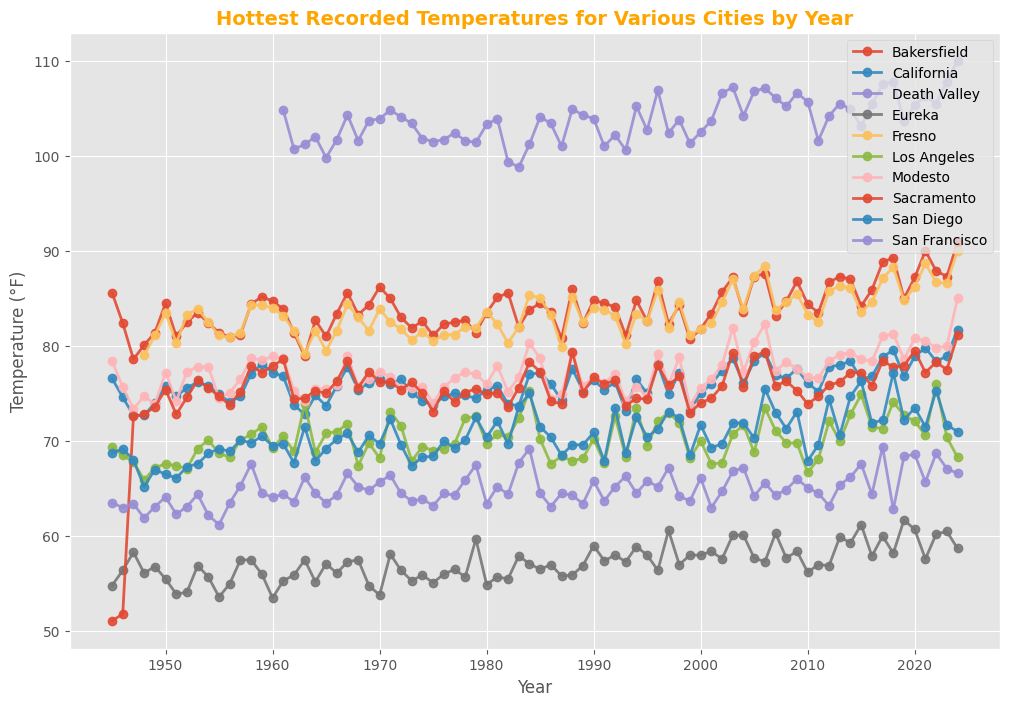

In [ ]:


# Assuming you have these DataFrames already prepared
cities_temps = [sf_temps_df, la_temps_df, sd_temps_df, sac_temps_df, bf_temps_df, erk_temps_df, dv_temps_df, fr_temps_df, mo_temps_df, ca_temps_df]

# Verify and rename the temperature column
for city_df in cities_temps:
    print(city_df.columns)  # Check column names
    city_df.rename(columns={'Value': 'Temperature'}, inplace=True)  # Replace 'Value' with actual name

# Merge all city temperature data into a single DataFrame
merged_temps_df = pd.concat(cities_temps, keys=['San Francisco', 'Los Angeles', 'San Diego', 'Sacramento', 'Bakersfield', 'Eureka', 'Death Valley', 'Fresno', 'Modesto', 'California'], names=['City'])

# Drop the 'City' column if it already exists to avoid conflicts
if 'City' in merged_temps_df.columns:
    merged_temps_df = merged_temps_df.drop(columns='City')

# Reset the index to make 'City' a column
merged_temps_df = merged_temps_df.reset_index()

# Ensure 'Year' column exists
if 'Year' not in merged_temps_df.columns:
    merged_temps_df['Year'] = merged_temps_df['Date'].dt.year

# Filter to keep only the hottest temperature for each city for each year
hottest_temps_per_year_df = merged_temps_df.loc[merged_temps_df.groupby(['City', 'Year'])['Temperature'].idxmax()]

# Plotting
plt.style.use('ggplot')
palette = plt.get_cmap('Set1')

# Plot the hottest temperature for each city for each year
plt.figure(figsize=(12, 8))
for city_name, city_df in hottest_temps_per_year_df.groupby('City'):
    plt.plot(city_df['Year'], city_df['Temperature'], marker='o', linestyle='-', linewidth=2, alpha=0.9, label=city_name)

# Add legend
plt.legend(loc='upper right', fontsize=10)

# Add titles and labels
plt.title("Hottest Recorded Temperatures for Various Cities by Year", fontsize=14, fontweight='bold', color='orange')
plt.xlabel("Year")
plt.ylabel("Temperature (°F)")

# Show the graph
plt.show()


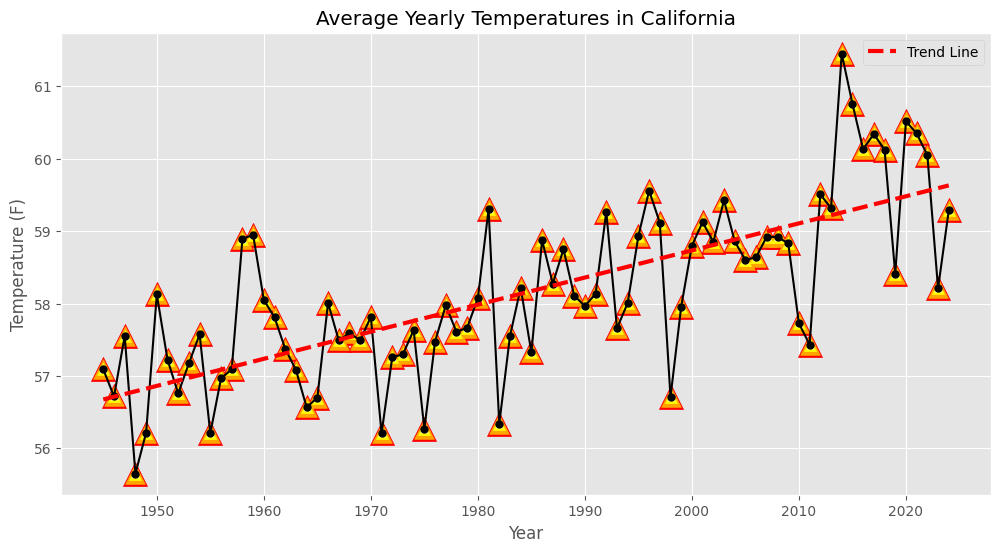

In [ ]:
# Connect to the SQLite database
conn = sqlite3.connect('ca_wildfires.db')
cursor = conn.cursor()

# Query the database to get average yearly temperatures
cursor.execute("SELECT Year, AVG(Temperature) AS avg_temp FROM ca_temps GROUP BY year")
rows = cursor.fetchall()

# Extract years and average temperatures from the query results
years = [row[0] for row in rows]
avg_temps = [row[1] for row in rows]

# Calculate the trend line using linear regression
coefficients = np.polyfit(years, avg_temps, 1)
trend_line = np.polyval(coefficients, years)

# Close the database connection
conn.close()

# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(years, avg_temps, color='black', marker='o', linestyle='-', markersize=5)
plt.plot(years, trend_line, color='r', linewidth=3, linestyle='--', label='Trend Line')
plt.xlabel('Year')
plt.ylabel('Temperature (F)')
plt.title('Average Yearly Temperatures in California')
plt.grid(True)
plt.legend()

# Customizing marker style to look like little fires
plt.scatter(years, avg_temps, marker='^', color='red', s=300, label='Fire Marker')
plt.scatter(years, avg_temps, marker='^', color='orange', s=200, label='Fire Marker')
plt.scatter(years, avg_temps, marker='^', color='yellow', s=75, label='Fire Marker')
plt.scatter(years, avg_temps, marker='^', color='white', s=25, label='Fire Marker')

plt.show()

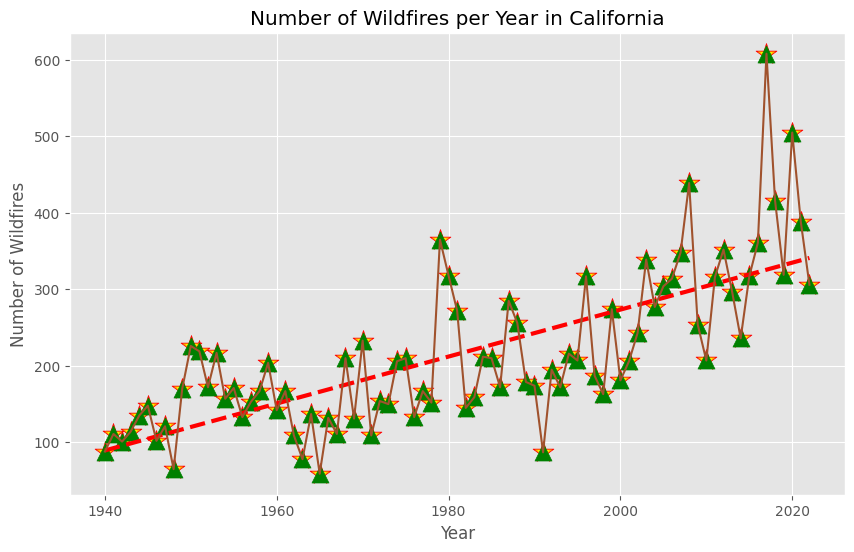

<Figure size 640x480 with 0 Axes>

In [ ]:
#Number of Wildfires per Year from 1940 to 2022
#Objective: Visualize the trend of wildfire occurrences over the years.
#Visualization: Line chart showing the number of wildfires per year.

# Connect to the SQLite database
conn = sqlite3.connect('ca_wildfires.db')

# Query the database to count the number of wildfires per year
query = "SELECT Year, COUNT(*) as Number_of_Wildfires FROM wildfires WHERE Year >= 1940 AND Year <= 2022 GROUP BY Year ORDER BY Year"
wildfire_counts = pd.read_sql(query, conn)

# Calculate the trend line using linear regression
coefficients = np.polyfit(wildfire_counts['Year'], wildfire_counts['Number_of_Wildfires'], 1)
trend_line = np.polyval(coefficients, wildfire_counts['Year'])

# Plot the number of wildfires per year
plt.figure(figsize=(10, 6))
plt.plot(wildfire_counts['Year'], trend_line, color='r', linewidth=3, linestyle='--', label='Trend Line')
plt.plot(wildfire_counts['Year'], wildfire_counts['Number_of_Wildfires'], color='sienna')
plt.title('Number of Wildfires per Year in California')
plt.xlabel('Year')
plt.ylabel('Number of Wildfires')
plt.grid(True)
plt.scatter(wildfire_counts['Year'], wildfire_counts['Number_of_Wildfires'], marker='*', color='red', s=250, label='Fire Marker')
plt.scatter(wildfire_counts['Year'], wildfire_counts['Number_of_Wildfires'], marker='*', color='orange', s=150, label='Fire Marker')
plt.scatter(wildfire_counts['Year'], wildfire_counts['Number_of_Wildfires'], marker='*', color='yellow', s=75, label='Fire Marker')
plt.scatter(wildfire_counts['Year'], wildfire_counts['Number_of_Wildfires'], marker='^', color='green', s=150, label='Fire Marker')
plt.show()

# Save the plot to a file  in image folder
# plt.savefig('Images/wildfires_per_year.png', dpi=300, bbox_inches='tight')

/var/folders/zq/hzzbbfwd5zn47ndkhw43kdf80000gn/T/ipykernel_60985/650803988.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year', y='Total_Acres_Burned', data=acres_burned, palette='OrRd')


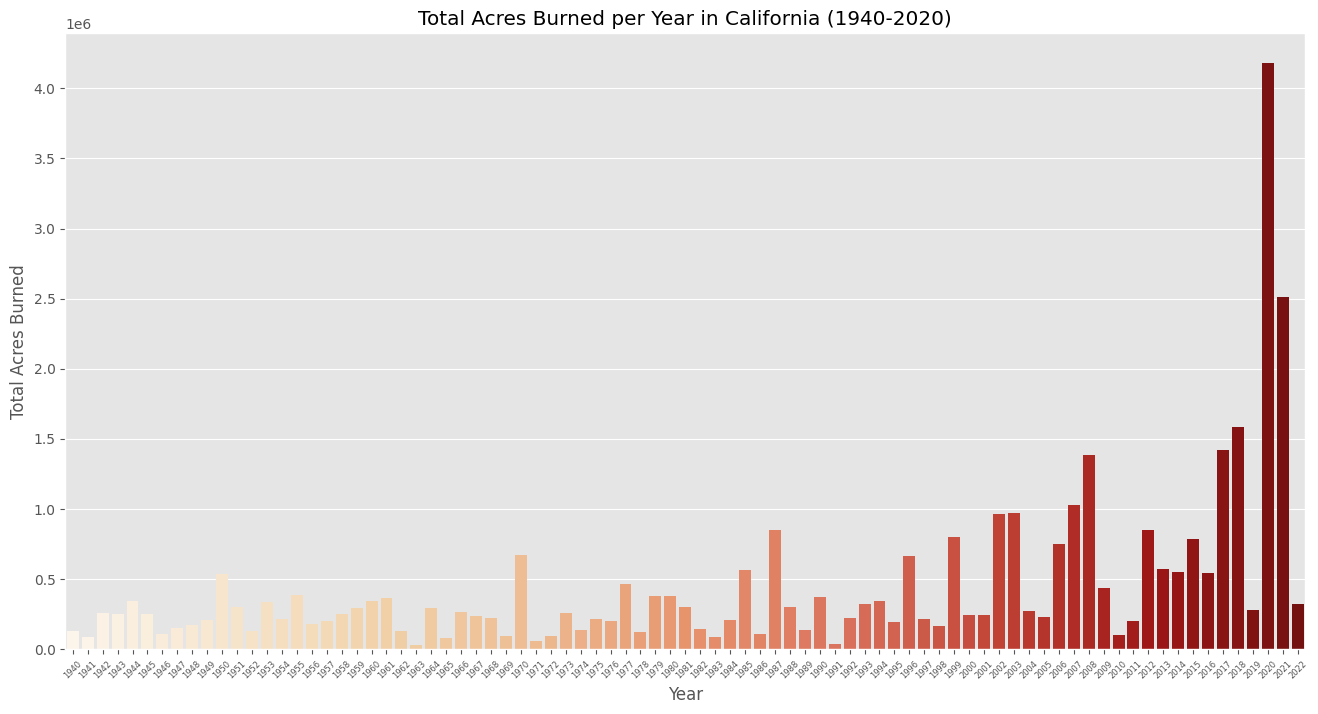

<Figure size 640x480 with 0 Axes>

In [ ]:
#Total Acres Burned per Year from 1940 to 2022
# Objective: Show the total area burned by wildfires each year.
# Visualization: Bar chart displaying the total acres burned annually.
# Connect to the SQLite database
# Connect to the SQLite database
conn = sqlite3.connect('ca_wildfires.db')

# Query the database to sum the acres burned per year (focus on 1940 to 2020)
query = 'SELECT Year, SUM("GIS Acres") as Total_Acres_Burned FROM wildfires WHERE Year >= 1940 AND Year <= 2022 GROUP BY Year ORDER BY Year'
acres_burned = pd.read_sql(query, conn)

# Convert Year to integer
acres_burned['Year'] = acres_burned['Year'].astype(int)

# Plot the total acres burned per year
plt.figure(figsize=(16, 8))  # Increase figure size for better readability
sns.barplot(x='Year', y='Total_Acres_Burned', data=acres_burned, palette='OrRd')
plt.title('Total Acres Burned per Year in California (1940-2020)')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')

# Rotate all x-axis labels to avoid overlap
plt.xticks(rotation=45, fontsize=6)

plt.show()

# Close the database connection
conn.close()

# # Save the plot to a file in image folder
# plt.savefig('Images/total_acres_burned_per_year.png', dpi=300, bbox_inches='tight')

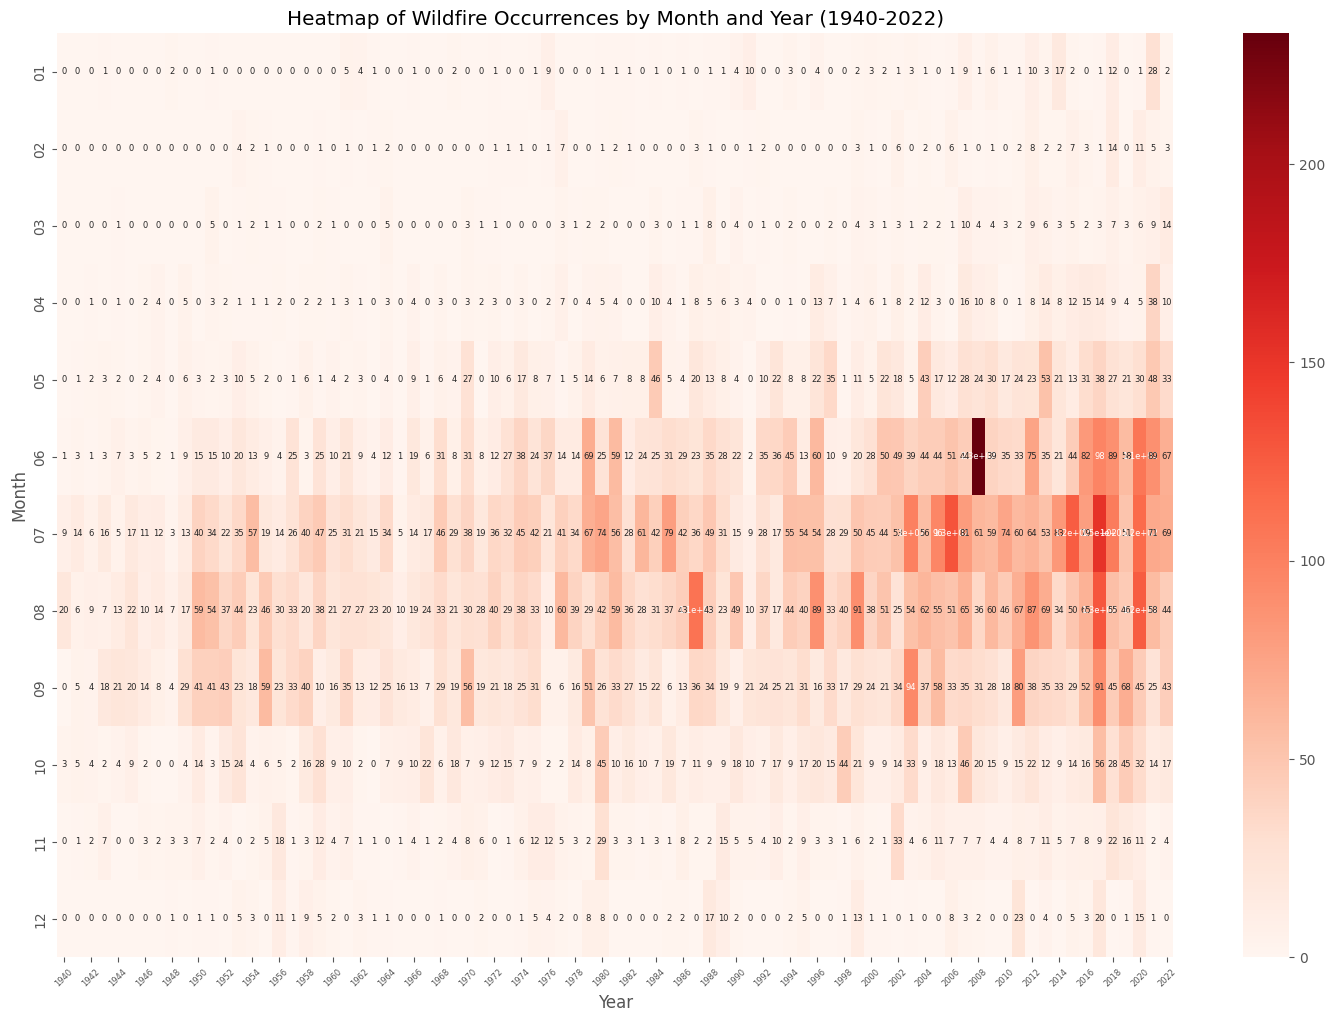

<Figure size 640x480 with 0 Axes>

In [ ]:
#Heatmap of Wildfire Occurrences by Month and Year
#Objective: Understand seasonal trends in wildfire occurrences.
#Visualization: Heatmap showing the number of wildfires by month and year.
# Connect to the SQLite database
conn = sqlite3.connect('ca_wildfires.db')

# Query the database to get the month and year of each fire
query = """
SELECT strftime('%Y', "Alarm Date") as Year, strftime('%m', "Alarm Date") as Month, COUNT(*) as Number_of_Wildfires 
FROM wildfires 
WHERE CAST(strftime('%Y', "Alarm Date") AS INTEGER) >= 1940 
AND CAST(strftime('%Y', "Alarm Date") AS INTEGER) <= 2022 
GROUP BY Year, Month 
ORDER BY Year, Month
"""
monthly_counts = pd.read_sql(query, conn)

# Ensure the Month and Year columns are strings
monthly_counts['Month'] = monthly_counts['Month'].astype(str)
monthly_counts['Year'] = monthly_counts['Year'].astype(str)

# Aggregate the data to ensure there are no duplicate Month-Year combinations
monthly_counts_agg = monthly_counts.groupby(['Month', 'Year'], as_index=False).sum()

# Pivot the data for heatmap
monthly_counts_pivot = monthly_counts_agg.pivot(index='Month', columns='Year', values='Number_of_Wildfires')

# Replace NaN values with 0 (for months/years with no wildfires)
monthly_counts_pivot = monthly_counts_pivot.fillna(0)

# Plot a heatmap of wildfire occurrences by month and year
plt.figure(figsize=(18, 12))
sns.heatmap(monthly_counts_pivot, cmap='Reds', annot=True, annot_kws={"size": 6})
plt.title('Heatmap of Wildfire Occurrences by Month and Year (1940-2022)')
plt.xlabel('Year')
plt.ylabel('Month')
# Rotate all x-axis labels to avoid overlap
plt.xticks(rotation=45, fontsize=6)
plt.show()

# Close the database connection
conn.close()

# Save the plot to a file
# plt.savefig('Images/wildfire_heatmap_month_year.png', dpi=300, bbox_inches='tight')

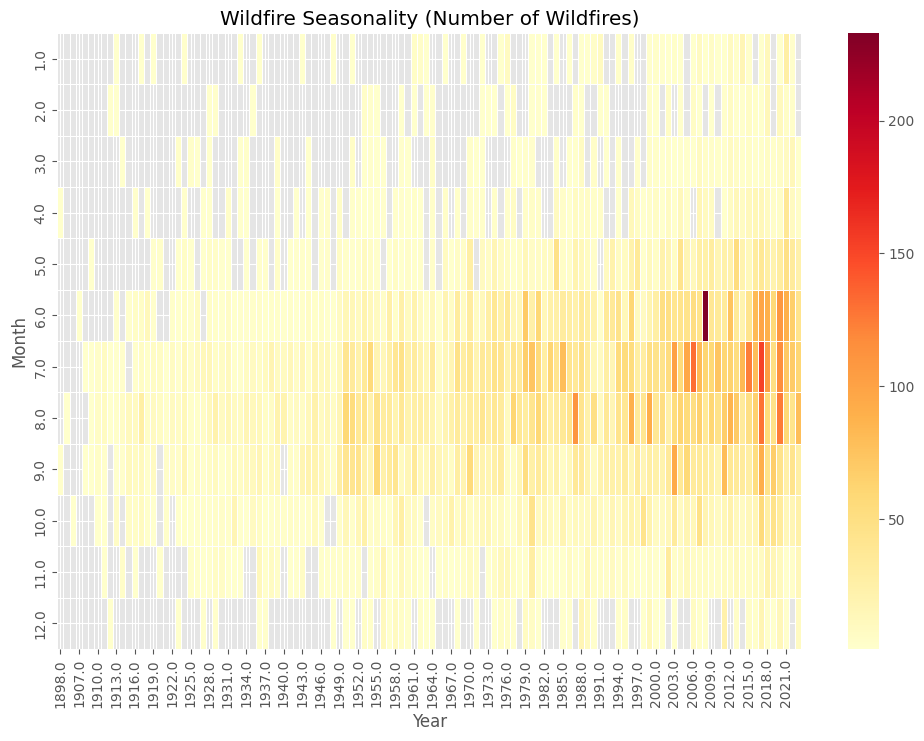

<Figure size 640x480 with 0 Axes>

In [ ]:
#Seasonality Analysis (Heatmap)
# Group by month and year
#Purpose: Analyze the seasonality of wildfires by visualizing the frequency or severity of wildfires by month across multiple years.
# Step 1: Connect to the SQLite database
conn = sqlite3.connect('ca_wildfires.db')

# Query to list all tables
# tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

# Load the wildfires data into a pandas DataFrame
query = "SELECT * FROM wildfires"
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

df['Alarm Date'] = pd.to_datetime(df['Alarm Date'])
df['Month'] = df['Alarm Date'].dt.month
seasonality = df.groupby(['Month', df['Alarm Date'].dt.year]).size().unstack()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(seasonality, cmap='YlOrRd', linewidths=.5)
plt.title('Wildfire Seasonality (Number of Wildfires)')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()


# Save the plot to a file
# plt.savefig('Images/wildfire_seasonality_fire_frequency', dpi=300, bbox_inches='tight')

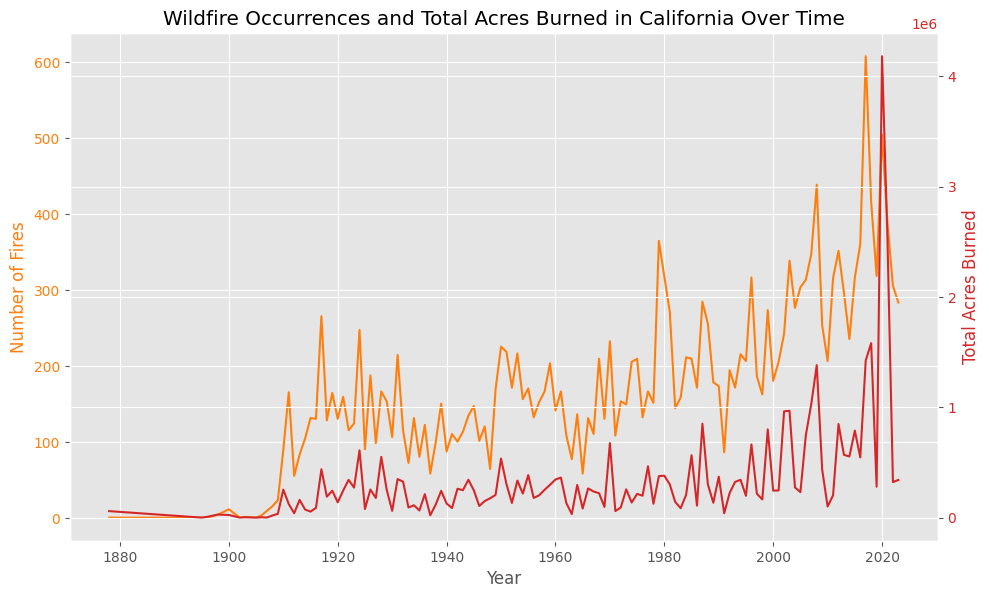

<Figure size 640x480 with 0 Axes>

In [ ]:
#Wildfire Occurrences and Acreage Burned
# Load data from the SQLite database
conn = sqlite3.connect('ca_wildfires.db')
wildfire_data = pd.read_sql('SELECT Year, COUNT(*) as num_fires, SUM("GIS Acres") as total_acres FROM wildfires GROUP BY Year', conn)
conn.close()

# Plot wildfire occurrences and acreage burned
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Fires', color='tab:orange')
ax1.plot(wildfire_data['Year'], wildfire_data['num_fires'], color='tab:orange', label='Number of Fires')
ax1.tick_params(axis='y', labelcolor='tab:orange')

ax2 = ax1.twinx()
ax2.set_ylabel('Total Acres Burned', color='tab:red')
ax2.plot(wildfire_data['Year'], wildfire_data['total_acres'], color='tab:red', label='Total Acres Burned')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Wildfire Occurrences and Total Acres Burned in California Over Time')
plt.show()

# Save the plot to a file
# plt.savefig('Images/wildfire_occurence_acres_over_time.png', dpi=300, bbox_inches='tight')

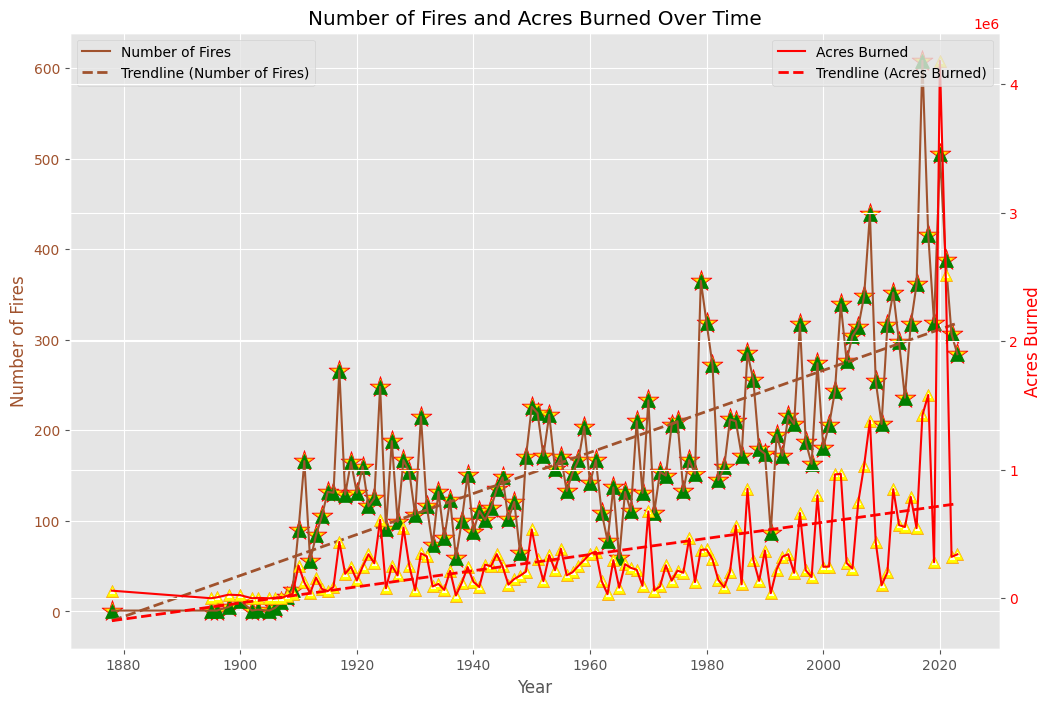

In [ ]:

conn = sqlite3.connect('ca_wildfires.db')
df = pd.read_sql('SELECT Year, COUNT(*) as num_fires, SUM("GIS Acres") as total_acres FROM wildfires GROUP BY Year', conn)
df = df.dropna(subset=['num_fires', 'total_acres', 'Year'])
conn.close()
# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot Number of Fires
ax1.plot(df['Year'], df['num_fires'], color='sienna', label='Number of Fires')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Fires', color='sienna')
ax1.tick_params(axis='y', labelcolor='sienna')

# Add a trendline for Number of Fires
slope, intercept, r_value, p_value, std_err = stats.linregress(df['Year'], df['num_fires'])
trendline = intercept + slope * df['Year']

# Plotting the trendline with a distinct style
ax1.plot(df['Year'], trendline, color='sienna', linestyle='--', label='Trendline (Number of Fires)', linewidth=2)

plt.scatter(df['Year'], df['num_fires'], marker='*', color='red', s=250)
plt.scatter(df['Year'], df['num_fires'], marker='*', color='orange', s=150)
plt.scatter(df['Year'], df['num_fires'], marker='*', color='yellow', s=75)
plt.scatter(df['Year'], df['num_fires'], marker='^', color='green', s=100)

# Plot Acres Burned on the same axes but with a different scale
ax2 = ax1.twinx()  # instantiate a second y-axis that shares the same x-axis
ax2.plot(df['Year'], df['total_acres'], color='r', label='Acres Burned')
ax2.set_ylabel('Acres Burned', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a trendline for Number of Fires
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(df['Year'], df['total_acres'])
trendline1 = intercept1 + slope1 * df['Year']

# Plotting the trendline with a distinct style
ax2.plot(df['Year'], trendline1, color='r', linestyle='--', label='Trendline (Acres Burned)', linewidth=2)

plt.scatter(df['Year'], df['total_acres'], marker='^', color='red')
plt.scatter(df['Year'], df['total_acres'], marker='^', color='orange', s=75)
plt.scatter(df['Year'], df['total_acres'], marker='^', color='yellow', s=50)
plt.scatter(df['Year'], df['total_acres'], marker='^', color='white', s=10)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.title('Number of Fires and Acres Burned Over Time')
plt.show()

In [ ]:
print(trendline)

1      -10.218011
2       28.296949
3       30.562534
4       35.093706
5       39.624878
          ...    
122    309.229593
123    311.495179
124    313.760765
125    316.026351
126    318.291937
Name: Year, Length: 126, dtype: float64


<h1>Interactive Map <h1>

In [55]:
#Interactive map to show fire location, acres burned and duration of the fire
# Connect to the SQLite database
conn = sqlite3.connect('ca_wildfires.db')

# Load the wildfires data into a pandas DataFrame
query = "SELECT * FROM wildfires"
df = pd.read_sql_query(query, conn)

# Remove rows with NA in the 'Alarm Date' column
df = df.dropna(subset=['Alarm Date', 'Containment Date', 'Latitude', 'Longitude', 'GIS Acres'])

# Close the connection
conn.close()

In [56]:
## Connect to the SQLite database
conn = sqlite3.connect('ca_wildfires.db')

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Define the table name
table_name = 'wildfires'

# Execute a query to get the table schema
cursor.execute(f'PRAGMA table_info({table_name})')

# Fetch the result
columns_info = cursor.fetchall()

# Extract column names
column_headers = [column[1] for column in columns_info]

# Print the column headers
print(column_headers)

# Close the connection
conn.close()

['ID', 'Year', 'State', 'Agency', 'Unit ID', 'Fire Name', 'Incident Number', 'Alarm Date', 'Containment Date', 'Cause', 'Date', 'GIS Acres', 'Comments', 'Complex Name', 'Fire Number', 'Decades', 'Latitude', 'Longitude']


In [57]:
# Initial data loading and processing
df['Alarm Date'] = pd.to_datetime(df['Alarm Date'])
df['duration_days'] = (pd.to_datetime(df['Containment Date']) - df['Alarm Date']).dt.days

# Ensure latitude and longitude are in float format
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)

# Check for any NA values in critical columns
print("Checking for NA values:")
print(df[['Latitude', 'Longitude', 'GIS Acres', 'duration_days']].isna().sum())

# Check some latitude and longitude values to ensure they are valid
print("Sample latitude and longitude values:")
print(df[['Latitude', 'Longitude']].head())


# Function to determine marker color based on duration
def color_producer(duration_days):
    if duration_days < 5:
        return 'green'
    elif 5 <= duration_days < 10:
        return 'orange'
    else:
        return 'red'

# Function to create and update the map based on the selected year
def update_map(year):
    m = folium.Map(location=[36.7783, -119.4179], zoom_start=6)
    marker_cluster = MarkerCluster().add_to(m)
    
    filtered_df = df[df['Alarm Date'].dt.year == year]
    print(f"Number of records for year {year}: {len(filtered_df)}")  # Debugging output
    
    for _, row in filtered_df.iterrows():
        # Define the custom .png image you want to use:
        custom_icon = 'Images/Flame_Icon.png.png'
        custom_icon = folium.features.CustomIcon(
            icon_image=custom_icon,
            # Set the size of the icon
            icon_size=(50, 50),
            # sett the anchor point of the icon
            icon_anchor=(15, 15)
    )
        # Update the Marker creation to use the custom icon:
        marker = folium.Marker(
        location=(row['Latitude'], row['Longitude']),
        icon=custom_icon,
        popup=folium.Popup(
            f"Acres Burned: {row['GIS Acres']}<br>Duration: {row['duration_days']} days<br>Fire Name: {row['Fire Name']}",
            max_width=200
        )
    )
        # Add the marker to the marker cluster
        marker.add_to(marker_cluster)
    return m


# Create a dropdown menu for selecting the year
years = df['Alarm Date'].dt.year.unique().tolist()
year_dropdown = widgets.Dropdown(options=sorted(years), description='Year:')

# Display the dropdown and the initial map
def display_map(year):
    m = update_map(year)
    display(m)

# Use interactive to link the dropdown to the map update function
interactive_map = widgets.interactive(display_map, year=year_dropdown)

# Display the interactive widget (dropdown) and the map
display(interactive_map)


Checking for NA values:
Latitude         0
Longitude        0
GIS Acres        0
duration_days    0
dtype: int64
Sample latitude and longitude values:
    Latitude   Longitude
0  41.532175 -122.912100
1  39.830743 -121.962853
2  38.295102 -120.904706
3  38.441969 -120.984186
4  38.247227 -120.995943


interactive(children=(Dropdown(description='Year:', options=(1912, 1921, 1922, 1924, 1925, 1926, 1927, 1928, 1…

In [ ]:
#Interactive map to show fire location, acres burned and duration of the fire
# Connect to the SQLite database
conn = sqlite3.connect('ca_wildfires.db')

# Load the wildfires data into a pandas DataFrame
query = "SELECT * FROM merged_table"
df1 = pd.read_sql_query(query, conn)

# Remove rows with NA in the 'Alarm Date' column
df1 = df1.dropna(subset=['Alarm Date', 'Containment Date', 'Latitude', 'Longitude', 'GIS Acres','Temperature'])

# Close the connection
conn.close()

In [ ]:
## Connect to the SQLite database
conn = sqlite3.connect('ca_wildfires.db')

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Define the table name
table_name = 'merged_table'

# Execute a query to get the table schema
cursor.execute(f'PRAGMA table_info({table_name})')

# Fetch the result
columns_info = cursor.fetchall()

# Extract column names
column_headers = [column[1] for column in columns_info]

# Print the column headers
print(column_headers)

# Close the connection
conn.close()

['ID', 'Year_x', 'State_x', 'Agency', 'Unit ID', 'Fire Name', 'Incident Number', 'Alarm Date', 'Containment Date', 'Cause', 'Date', 'GIS Acres', 'Comments', 'Complex Name', 'Fire Number', 'Decades', 'Latitude', 'Longitude', 'State_y', 'Year_y', 'Month', 'Temperature']


In [ ]:
df1.columns

Index(['ID', 'Year_x', 'State_x', 'Agency', 'Unit ID', 'Fire Name',
       'Incident Number', 'Alarm Date', 'Containment Date', 'Cause', 'Date',
       'GIS Acres', 'Comments', 'Complex Name', 'Fire Number', 'Decades',
       'Latitude', 'Longitude', 'State_y', 'Year_y', 'Month', 'Temperature'],
      dtype='object')

In [ ]:
# Initial data loading and processing
df1['Alarm Date'] = pd.to_datetime(df1['Alarm Date'])
df1['duration_days'] = (pd.to_datetime(df1['Containment Date']) - df1['Alarm Date']).dt.days

# Ensure latitude and longitude are in float format
df1['Latitude'] = df1['Latitude'].astype(float)
df1['Longitude'] = df1['Longitude'].astype(float)
df1['Temperature'] = df1['Temperature'].astype(float)

# Check for any NA values in critical columns
print("Checking for NA values:")
print(df1[['Latitude', 'Longitude', 'GIS Acres', 'duration_days', 'Temperature']].isna().sum())

# Check some latitude and longitude values to ensure they are valid
print("Sample latitude and longitude values:")
print(df1[['Latitude', 'Longitude']].head())


# Function to determine marker color based on duration
def color_producer(duration_days):
    if duration_days < 5:
        return 'green'
    elif 5 <= duration_days < 10:
        return 'orange'
    else:
        return 'red'

# Function to create and update the map based on the selected year
def update_map(year):
    m = folium.Map(location=[36.7783, -119.4179], zoom_start=6)
    marker_cluster = MarkerCluster().add_to(m)
    
    filtered_df1 = df1[df1['Alarm Date'].dt.year == year]
    print(f"Number of records for year {year}: {len(filtered_df1)}")  # Debugging output
    
    for _, row in filtered_df1.iterrows():
        # print(f"Placing marker at ({row['Latitude']}, {row['Longitude']}) with radius {row['GIS Acres']}")
        # folium.Marker(
        #     location=(row['Latitude'], row['Longitude']),
        #     popup=folium.Popup(f"Acres Burned: {row['GIS Acres']}<br>Duration: {row['duration_days']} days", max_width=200)
        # ).add_to(marker_cluster)
        
        folium.CircleMarker(
            location=(row['Latitude'], row['Longitude']),
            radius=max(1, row['GIS Acres'] / 1000),  # Adjust size according to acres burned
            color=color_producer(row['duration_days']),
            fill=True,
            fill_color=color_producer(row['duration_days']),
            fill_opacity=0.7,
            popup=folium.Popup(f"Acres Burned: {row['GIS Acres']}<br>Duration: {row['duration_days']} days<br>Fire Name: {row['Fire Name']}<br>Temperature: {row['Temperature']} ", max_width=200)
        ).add_to(marker_cluster)
    
    return m

# Create a dropdown menu for selecting the year
years = df1['Alarm Date'].dt.year.unique().tolist()
year_dropdown = widgets.Dropdown(options=sorted(years), description='Year:')

# Display the dropdown and the initial map
def display_map(year):
    m = update_map(year)
    display(m)

# Use interactive to link the dropdown to the map update function
interactive_map = widgets.interactive(display_map, year=year_dropdown)

# Display the interactive widget (dropdown) and the map
display(interactive_map)


Checking for NA values:
Latitude         0
Longitude        0
GIS Acres        0
duration_days    0
Temperature      0
dtype: int64
Sample latitude and longitude values:
    Latitude   Longitude
0  41.532175 -122.912100
1  39.830743 -121.962853
2  38.295102 -120.904706
3  38.441969 -120.984186
4  38.247227 -120.995943


interactive(children=(Dropdown(description='Year:', options=(1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1…

In [ ]:
#Heatmap of wildfire duration
#Duration of Wildfires Over Time
conn = sqlite3.connect('wildfire.db')

# Query to list all tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

# Close the connection
conn.close()

# Function to filter data by year and update the heatmap
def update_heatmap(year):
    # Filter data for the selected year
    filtered_df = df[df['Alarm Date'].dt.year == year]
    
    # Prepare the data for the heatmap
    heat_data = [[row['Latitude'], row['Longitude']] for index, row in filtered_df.iterrows()]
    
    # Create a base map
    m = folium.Map(location=[36.7783, -119.4179], zoom_start=6)
    
    # Add the heatmap
    HeatMap(heat_data).add_to(m)
    
    # Display the map
    display(m)

# Create a dropdown menu for selecting the year
years = df['Alarm Date'].dt.year.unique().tolist()
year_dropdown = widgets.Dropdown(options=sorted(years), description='Year:')

# Use interactive to link the dropdown to the heatmap update function
widgets.interactive(update_heatmap, year=year_dropdown)

interactive(children=(Dropdown(description='Year:', options=(1912, 1921, 1922, 1924, 1925, 1926, 1927, 1928, 1…

In [ ]:
df1.head()

,ID,Year_x,State_x,Agency,Unit ID,Fire Name,Incident Number,Alarm Date,Containment Date,Cause,...,Complex Name,Fire Number,Decades,Latitude,Longitude,State_y,Year_y,Month,Temperature,duration_days
0,1,2023.0,CA,CDF,SKU,WHITWORTH,00004808,2023-06-17,2023-06-17 00:00:00,5.0,...,None,None,2020.0,41.532175,-122.912100,CA,2023.0,6.0,66.9,0
1,2,2023.0,CA,LRA,BTU,KAISER,00010225,2023-06-02,2023-06-02 00:00:00,5.0,...,None,None,2020.0,39.830743,-121.962853,CA,2023.0,6.0,66.9,0
2,3,2023.0,CA,CDF,AEU,JACKSON,00017640,2023-07-01,2023-07-02 00:00:00,2.0,...,None,None,2020.0,38.295102,-120.904706,CA,2023.0,7.0,78.9,1
3,4,2023.0,CA,CDF,AEU,CARBON,00018821,2023-07-11,2023-07-11 00:00:00,9.0,...,None,None,2020.0,38.441969,-120.984186,CA,2023.0,7.0,78.9,0
4,5,2023.0,CA,CDF,AEU,LIBERTY,00018876,2023-07-11,2023-07-12 00:00:00,14.0,...,None,None,2020.0,38.247227,-120.995943,CA,2023.0,7.0,78.9,1


In [ ]:
#Heatmap of wildfire duration
#Duration of Wildfires Over Time
conn = sqlite3.connect('wildfire.db')

# Query to list all tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

# Close the connection
conn.close()

# Ensure df1 is properly loaded and processed
df1['Alarm Date'] = pd.to_datetime(df1['Alarm Date'])
df1['Latitude'] = df1['Latitude'].astype(float)
df1['Longitude'] = df1['Longitude'].astype(float)
df1['Temperature'] = df1['Temperature'].astype(float)

# Function to filter data by year and update the heatmap
def update_heatmap(year):
    # Filter data for the selected year
    filtered_df1 = df1[df1['Alarm Date'].dt.year == year]
    
    # Prepare the data for the heatmap, using temperature as a weight
    heat_data = [
        [row['Latitude'], row['Longitude'], row['Temperature']]
        for index, row in filtered_df1.iterrows()
    ]
    
    # Create a base map
    m = folium.Map(location=[36.7783, -119.4179], zoom_start=6)
    
    # Add the heatmap with temperature as a weighting factor
    HeatMap(heat_data).add_to(m)
    
    # Display the map
    display(m)

# Create a dropdown menu for selecting the year
years = df1['Alarm Date'].dt.year.unique().tolist()
year_dropdown = widgets.Dropdown(options=sorted(years), description='Year:')

# Use interactive to link the dropdown to the heatmap update function
interactive_map = widgets.interactive(update_heatmap, year=year_dropdown)

# Display the interactive widget (dropdown) and the map
display(interactive_map)

interactive(children=(Dropdown(description='Year:', options=(1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1…